# Cab-Driver Agent

                                                                                    - Rajagopal Shenoy G
                                                                                    - Anindya Sudhir

In [1]:
# Importing libraries
import numpy as np
import random
import math
import time
from collections import deque
import collections
import pickle

# for building DQN model
from keras import layers
from keras import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam
from keras.models import load_model
# for plotting graphs
import matplotlib.pyplot as plt

# Import the environment
from Env import CabDriver

Using TensorFlow backend.


## Defining Time Matrix

- Let us try to understand the Time Matrix

In [2]:
# Loading the time matrix provided
Time_matrix = np.load("TM.npy")
print('Shape of Time Matrix:', Time_matrix.shape)

# Get the maximum time taken for a ride available in Time Matrix
print('Maximum time taken for a ride:', Time_matrix.max())

# Get the minimum time taken for a ride available in Time Matrix
print('Minimum time taken for a ride:', Time_matrix.min())

Shape of Time Matrix: (5, 5, 24, 7)
Maximum time taken for a ride: 11.0
Minimum time taken for a ride: 0.0


### There are some rides which have taken 0 hours in the Time Matrix

In [3]:
# Interestingly, there are some rides which have taken 0 hours. Let us check them
count_zero = 0
for p in range(Time_matrix.shape[0]):
    for q in range(Time_matrix.shape[1]):
        for hour in range(Time_matrix.shape[2]):
            for day in range(Time_matrix.shape[3]):
                # Get the rides with 0 ride time where start and end locations are not same
                if (Time_matrix[p][q][hour][day] == 0) and (p != q):
                    print(p+1, q+1, hour, day)
                    count_zero += 1
print('Total counts with ride times as 0 between two locations:', count_zero)

1 2 0 5
1 2 1 5
1 2 2 5
1 2 3 5
1 2 4 5
1 2 5 5
1 4 12 6
1 4 13 6
1 4 14 6
1 4 15 6
1 4 16 6
1 4 17 6
1 4 18 0
1 4 19 0
1 4 20 0
1 4 21 0
1 4 22 0
1 4 23 0
1 5 0 3
1 5 1 3
1 5 2 3
1 5 3 3
1 5 4 3
1 5 5 3
1 5 6 4
1 5 6 5
1 5 7 4
1 5 7 5
1 5 8 4
1 5 8 5
1 5 9 4
1 5 9 5
1 5 10 4
1 5 10 5
1 5 11 4
1 5 11 5
1 5 12 3
1 5 12 5
1 5 13 3
1 5 13 5
1 5 14 3
1 5 14 5
1 5 15 3
1 5 15 5
1 5 16 3
1 5 16 5
1 5 17 3
1 5 17 5
2 1 0 5
2 1 1 5
2 1 2 5
2 1 3 5
2 1 4 5
2 1 5 5
2 4 12 6
2 4 13 6
2 4 14 6
2 4 15 6
2 4 16 6
2 4 17 6
2 4 18 6
2 4 19 6
2 4 20 6
2 4 21 6
2 4 22 6
2 4 23 6
2 5 12 0
2 5 12 1
2 5 12 2
2 5 12 3
2 5 12 5
2 5 13 0
2 5 13 1
2 5 13 2
2 5 13 3
2 5 13 5
2 5 14 0
2 5 14 1
2 5 14 2
2 5 14 3
2 5 14 5
2 5 15 0
2 5 15 1
2 5 15 2
2 5 15 3
2 5 15 5
2 5 16 0
2 5 16 1
2 5 16 2
2 5 16 3
2 5 16 5
2 5 17 0
2 5 17 1
2 5 17 2
2 5 17 3
2 5 17 5
2 5 18 1
2 5 18 3
2 5 18 4
2 5 19 1
2 5 19 3
2 5 19 4
2 5 20 1
2 5 20 3
2 5 20 4
2 5 21 1
2 5 21 3
2 5 21 4
2 5 22 1
2 5 22 3
2 5 22 4
2 5 23 1
2 5 23 3
2 5 23 4


- This happens due to the fact that some rides have taken less than an hour, so are considered as 0 in the Time Matrix (rounding off)
- We need not do anything here, just let it be like that (Even Mr. Manish Kumar confirmed this during the live session)

## Support functions
- Define custom support functions like epsilon-decay, saving the model, tracking states etc 

### Epsilon - decay check

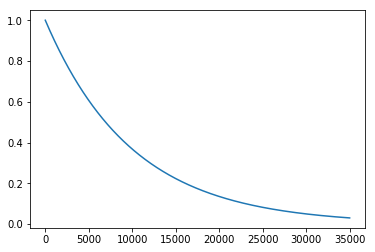

In [4]:
max_epsilon = 1.0
min_epsilon = 0
episodesNum = np.arange(0,35000)
epsilon = []
for i in range(0,35000):
    epsilon.append(min_epsilon + (max_epsilon - min_epsilon) * np.exp(-0.00010*i))
plt.plot(episodesNum, epsilon)
plt.show()

- -0.00010 decay rate is giving a nice decay graph. 
- We plan to train the model for 35 thousands episodes so we will try the same decay rate there too

### Tracking the state-action pairs for checking convergence


In [5]:
# Initialise Q_dictionary as 'Q_dict' and States_tracked as 'States_track' (for convergence)
Q_dict = collections.defaultdict(dict)
states_tracked = collections.defaultdict(dict)

In [6]:
# Initialise states to be tracked
def initialise_tracking_states():
    # Initialize some 6 Q-values which need to be tracked for checking convergence
    sample_q_values = [((2,17,6), (4,5)), ((4,22,5),(2,5)), ((2,4,1),(0,0)), 
                        ((1,18,3),(4,2)), ((3,12,6),(1,4)), ((4,6,2),(4,3))]                      
    for q_values in sample_q_values:
        state = q_values[0]
        action = q_values[1]
        states_tracked[state][action] = []

In [7]:
def save_tracking_states():
    for state in states_tracked.keys():
        for action in states_tracked[state].keys():
            if state in Q_dict and action in Q_dict[state]:
                states_tracked[state][action].append(Q_dict[state][action])

In [8]:
# Defining a function which will return valid (all possible actions) actions corresponding to a state
# Important to avoid errors during deployment.

def valid_actions(state):
    # All possible actions from the current state are taken
    valid_actions = [i for i in env.action_space if i[0] == state[0]]   
    valid_actions.append((0,0))
    return valid_actions

In [9]:
# Defining a function which will add new Q-values to the Q-dictionary. 
def add_to_dict(state):
    #valid_act = valid_actions(state)
    if state not in Q_dict.keys():
        for action in env.action_space: #valid_act:
            Q_dict[state][action] = 0

In [10]:
#Defining a function to save the Q-dictionary as a pickle file
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

In [11]:
initialise_tracking_states()

## Agent Class

If you are using this framework, you need to fill the following to complete the following code block:
1. State and Action Size
2. Hyperparameters
3. Create a neural-network model in function 'build_model()'
4. Define epsilon-greedy strategy in function 'get_action()'
5. Complete the function 'append_sample()'. This function appends the recent experience tuple <state, action, reward, new-state> to the memory
6. Complete the 'train_model()' function with following logic:
   - If the memory size is greater than mini-batch size, you randomly sample experiences from memory as per the mini-batch size and do the following:
      - Initialise your input and output batch for training the model
      - Calculate the target Q value for each sample: reward + gamma*max(Q(s'a,))
      - Get Q(s', a) values from the last trained model
      - Update the input batch as your encoded state-action and output batch as your Q-values
      - Then fit your DQN model using the updated input and output batch.

In [12]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        # Define size of state and action
        self.state_size = state_size
        self.action_size = action_size
        
        # The Cab Driver Environment
        self.env = CabDriver()

        # Write here: Specify your hyper parameters for the DQN
        # After several trial and error (not shown in code), following values are chosen
        self.discount_factor = 0.95
        self.learning_rate = 0.01      
        self.epsilon_max = 1.0
        self.epsilon_decay = 0.00010
        self.epsilon_min = 0.0
        self.batch_size = 32        
        
        # Create replay memory using deque
        self.memory = deque(maxlen=2000)

        # Create main model and target model
        self.model = self.build_model()
        self.target_model = self.build_model()

        # Initialize the target model
        self.update_target_model()

    # Approximate Q function using Neural Network as per Architecture 1
    def build_model(self):
        model = Sequential()
        
        # Hidden layers
        model.add(Dense(32, input_dim = self.state_size, activation = 'relu', kernel_initializer = 'he_uniform'))
        model.add(Dense(32, activation = 'relu', kernel_initializer = 'he_uniform'))
        model.add(Dense(self.action_size, activation = 'linear', kernel_initializer = 'he_uniform'))
        
        model.compile(loss = 'mse', optimizer = Adam(lr = self.learning_rate))
        model.summary
        return model

    # After some time intervals, update the target model to be same with model
    def update_target_model(self):
        '''
        Update the target Q-value network to current Q-value network after training for a episode. This means that weights an
        biases of target Q-value network will become same as current Q-value network.
        '''
        self.target_model.set_weights(self.model.get_weights())
        
    # Get action from model using epsilon-greedy policy
    def get_action(self, state, time):
        # Write your code here:
        # get action from model using epsilon-greedy policy
        # Decay in ε after we generate each sample from the environment 
        
        epsilon = self.epsilon_min + (self.epsilon_max - self.epsilon_min) * np.exp(-self.epsilon_decay*time)
        
        if np.random.rand() <= epsilon:
            # Exploration: choose a random action from all possible actions
            actions = self.env.requests(state)
            action = random.choice(actions)
        else:
            # Exploitation: choose the action with the highest q(s, a)
            encoded_state = self.env.state_encod_arch1(state)
            q_value = self.model.predict(encoded_state)
            action = self.env.action_space[np.argmax(q_value[0])]
        
        return action  

    # Calculate the Q value
    def calc_q(self, state, action):
        # Q-value is calculated from the NN model by sending the state as one hot encoded input
        state_onehot = self.env.state_encod_arch1(state)
        q_value = self.model.predict(state_onehot)
        action_index = self.env.action_space.index(action)
        
        return q_value[0][action_index]
    
    # Save sample <s,a,r,s'> to the replay memory
    def append_sample(self, state, action, reward, next_state, done):
        # Write your code here:
        # save sample <s,a,r,s'> to the replay memory
        self.memory.append((state, action, reward, next_state, done))

    # pick samples randomly from replay memory (with batch_size) and train the network
    def train_model(self):
        """
        Train the neural network over a minibatch. Input to the network is the states,
        output is the target q-value corresponding to each action.
        """
        
        if len(self.memory) >= self.batch_size:
            # Sample batch from the memory
            mini_batch = random.sample(self.memory, self.batch_size)
            update_target = np.zeros((self.batch_size, self.state_size))
            update_input = np.zeros((self.batch_size, self.state_size))
            action, reward, done = [], [], []
            
            # Set the values of input, action, reward, target and done using memory
            for i in range(self.batch_size):
                update_input[i] = self.env.state_encod_arch1(mini_batch[i][0])
                update_target[i] = self.env.state_encod_arch1(mini_batch[i][3])
                action.append(mini_batch[i][1])
                reward.append(mini_batch[i][2])
                done.append(mini_batch[i][4])

            # 1. Predict the target from earlier model
            target = self.model.predict(update_input)
                
            # 2. Get the target for the Q-network
            target_val = self.target_model.predict(update_target)
                
            #3. Update your 'update_output' and 'update_input' batch. Be careful to use the encoded state-action pair
            for i in range(self.batch_size):
                action_index = self.env.action_space.index(action[i])
                if done[i]:
                    target[i][action_index] = reward[i]
                else:
                    target[i][action_index] = reward[i] + self.discount_factor * (np.amax(target_val[i]))

            # 4. Fit your model and track the loss values
            self.model.fit(update_input, target, batch_size = self.batch_size, epochs = 1, verbose = 0)

    def save(self, name):
        self.model.save(name)

## DQN block

In [13]:
# Keep a track of total rewards and steps per episode
total_rewards = []
total_steps = []

In [14]:
# Call the environment
env = CabDriver()

In [15]:
def trainer(episodes):
    
    start_time = time.time()
    
    initialise_tracking_states()
    
    # Call the DQN agent
    agent = DQNAgent(env.state_size, env.action_size)    
        
    for episode in range(episodes):

        # Call all the initialised variables of the environment
        terminal_state = False
        state = env.reset()
               
        # Rewards counter
        rewards = 0
        
        # Number of steps taken by agent
        agent_steps = 0
    
        while not terminal_state:     
            # Write your code here
            
            add_to_dict(state) # Update the dictionary with the current state
            
            # Get action for the current state and go one step in environment
            # 1. Pick epsilon-greedy action from possible actions for the current state
            action = agent.get_action(state, episode)
            
            # 2. Evaluate your reward and next state
            reward, next_state, terminal_state = env.step(state, action, Time_matrix)
            
            # Save the sample <s, a, r, s'> to the replay memory
            # 3. Append the experience to the memory
            agent.append_sample(state, action, reward, next_state, terminal_state)
            
            # Every time step do the training
            # 4. Train the model by calling function agent.train_model
            agent.train_model()

            # 5a. Keep a track of rewards, Q-values, loss
            # Tracking the Q-values for selected state-action pairs
            Q_dict[state][action] += agent.calc_q(state, action)

            # Update the count of number of steps taken by agent and the rewards
            agent_steps += 1
            rewards += reward

            # Go to next state
            state = next_state
            
        # Update the NN model weights
        agent.update_target_model()
            
        # 5b. Keep a track of rewards, Q-values, loss
        # Update total awards and steps per episode
        total_steps.append(agent_steps)
        total_rewards.append(rewards)
          
        if ((episode + 1) % 1000) == 0:   # every 1000th episode
            save_tracking_states()
            
        print('Progress: '+ str(round(episode/episodes*100,2)) + '%',  end='\r')                  
    
    # Final Progress Report
    elapsed_time = time.time() - start_time
    print('\033[1m' + 'Final Progress Report:' + '\033[0m')
    print('Total execution time:                              {:.2f} seconds'.format(elapsed_time))
    print('Total number of rides :                           ', sum(total_steps))
    print('Average rides taken by the driver per 30 days:    ', round(sum(total_steps) / episodes, 2))
    print('Total rewards :                                   ', sum(total_rewards))
    print('Average rewards earned by the driver per 30 days: ', round(sum(total_rewards) / episodes, 2))
        
    # Save the tracked states and Policy
    save_obj(states_tracked,'States_tracked')
    save_obj(Q_dict,'Policy')
    agent.save('nnmodel.h5')

## Run the model

In [16]:
# Let us run the model for 35000 episodes and track the values
trainer(35000)

Final Progress Report:
Total execution time:                              14471.48 seconds
Total number of rides :                            4033535
Average rides taken by the driver per 30 days:     115.24
Total rewards :                                    49887067
Average rewards earned by the driver per 30 days:  1425.34


### Check the Q-dictionary

In [17]:
Q_dict

defaultdict(dict,
            {(2, 4, 1): {(1, 2): 63655.84375,
              (1, 3): 78209.3717956543,
              (1, 4): 60558.66552734375,
              (1, 5): 82332.08818054199,
              (2, 1): 277387.8720397949,
              (2, 3): 4897130.931152344,
              (2, 4): 95136.38716125488,
              (2, 5): 78115.94371032715,
              (3, 1): 88268.22291183472,
              (3, 2): 88140.31756591797,
              (3, 4): 66709.35539245605,
              (3, 5): 82248.7318572998,
              (4, 1): 72250.88729858398,
              (4, 2): 71162.7939991951,
              (4, 3): 102307.32727622986,
              (4, 5): 115521.40420532227,
              (5, 1): 79731.94262695312,
              (5, 2): 83067.58279418945,
              (5, 3): 124509.06051635742,
              (5, 4): 93909.9169921875,
              (0, 0): 101333.25325012207},
             (2, 12, 1): {(1, 2): 20579.953033447266,
              (1, 3): 38239.4274597168,
              (1, 4):

In [18]:
len(Q_dict)

840

In [19]:
states_tracked

defaultdict(dict,
            {(2,
              17,
              6): {(4, 5): [51652.32702636719,
               69207.81771850586,
               75251.87509155273,
               80044.6852722168,
               86166.88339233398,
               89175.60556030273,
               89497.86618041992,
               91090.96295166016,
               93371.67623901367,
               95070.56265258789,
               95748.75842285156,
               97575.54455566406,
               99068.4016418457,
               99068.4016418457,
               99068.4016418457,
               99443.8095703125,
               99811.17977905273,
               99811.17977905273,
               99811.17977905273,
               99811.17977905273,
               100508.46765136719,
               101378.37777709961,
               102433.71520996094,
               103080.12142944336,
               103080.12142944336,
               103420.35122680664,
               103420.35122680664,
              

### Tracking Convergence

- Check for value convergence of the few tracked state-action pairs
- Also check for how rewards improve over time

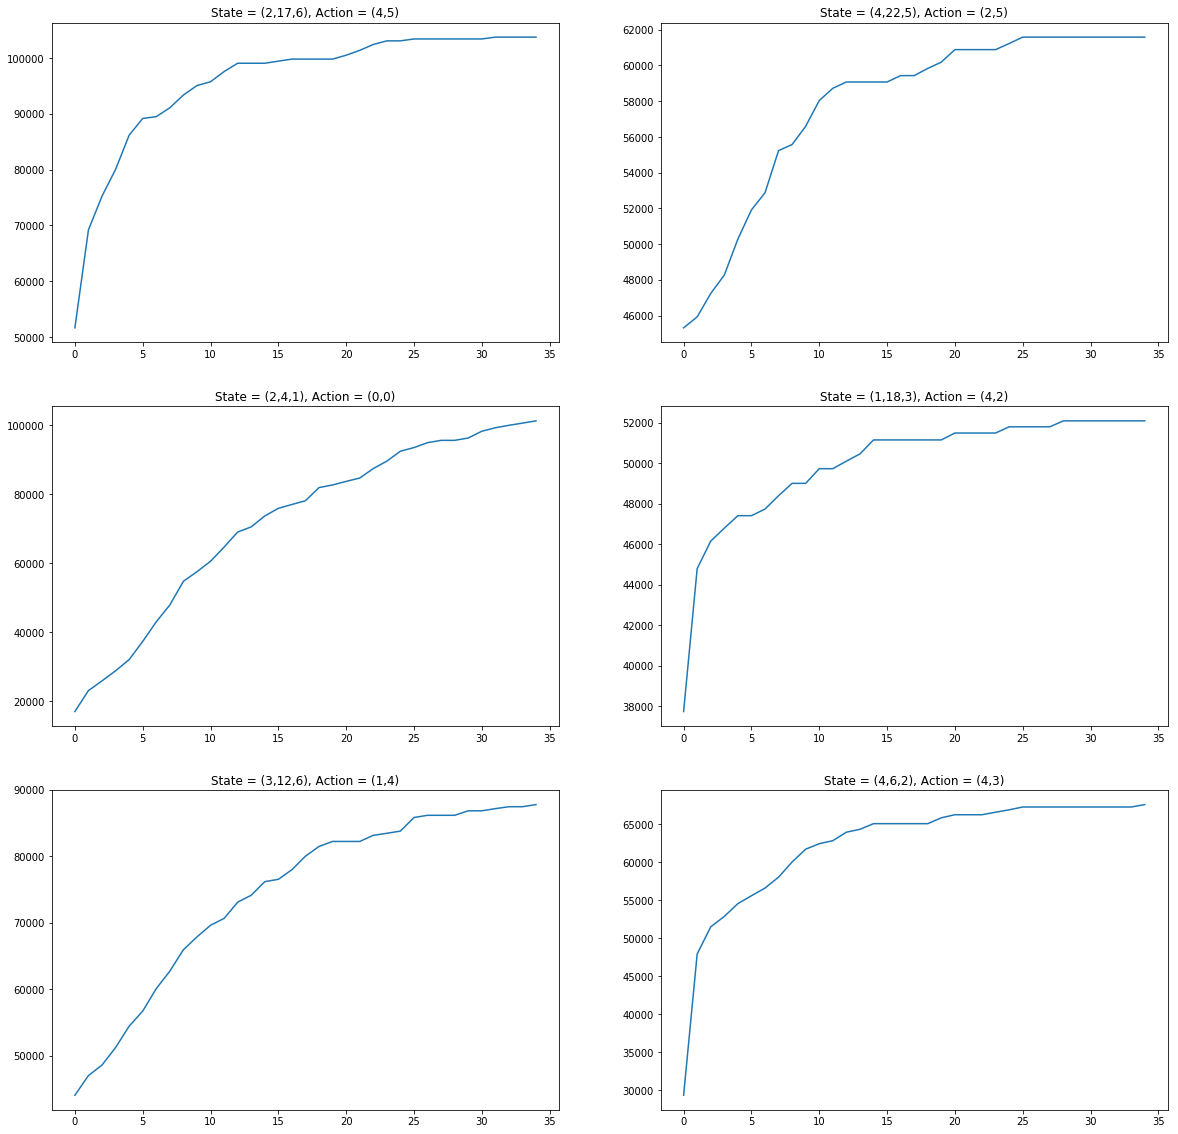

In [20]:
# Write the code for plotting the graphs for state-action pairs tracked
plt.figure(0, figsize=(20,20))

plt.subplot(321)
plt.title('State = (2,17,6), Action = (4,5)')
plt.plot(np.asarray(range(0, len(states_tracked[(2,17,6)][(4,5)]))),
         np.asarray(states_tracked[(2,17,6)][(4,5)]))

plt.subplot(322)
plt.title('State = (4,22,5), Action = (2,5)')
plt.plot(np.asarray(range(0, len(states_tracked[(4,22,5)][(2,5)]))), \
         np.asarray(states_tracked[(4,22,5)][(2,5)]))

plt.subplot(323)
plt.title('State = (2,4,1), Action = (0,0)')
plt.plot(np.asarray(range(0, len(states_tracked[(2,4,1)][(0,0)]))), \
         np.asarray(states_tracked[(2,4,1)][(0,0)]))

plt.subplot(324)
plt.title('State = (1,18,3), Action = (4,2)')
plt.plot(np.asarray(range(0, len(states_tracked[(1,18,3)][(4,2)]))), \
         np.asarray(states_tracked[(1,18,3)][(4,2)]))

plt.subplot(325)
plt.title('State = (3,12,6), Action = (1,4)')
plt.plot(np.asarray(range(0, len(states_tracked[(3,12,6)][(1,4)]))), \
         np.asarray(states_tracked[(3,12,6)][(1,4)]))

plt.subplot(326)
plt.title('State = (4,6,2), Action = (4,3)')
plt.plot(np.asarray(range(0, len(states_tracked[(4,6,2)][(4,3)]))), \
         np.asarray(states_tracked[(4,6,2)][(4,3)]))

plt.show()

### Plotting Model Improvement over time (episodes):

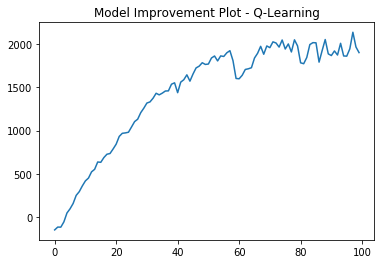

In [21]:
# See if the model keeps improving over time (episodes)
rewards_arr = np.array(total_rewards)
n = rewards_arr.size
rew_arr_new = rewards_arr[:(n // 100) * 100].reshape(100, -1) # Converting the rewards to (100, 50000)
y = rew_arr_new.mean(axis = 1) # Taking mean of every 50k records
plt.title("Model Improvement Plot - Q-Learning")
plt.plot(y)

- As seen above, the Q-values are converging well over time (episodes)
- Results obtained are very good and the model has learnt well
- Experiment has taken lot of time to run ~4 hours (14471 seconds)
- Hence we stop the experiment now

## Load the final model and run cab for few episodes
- See if the model is saved correctly and is able to execute when loaded

In [22]:
# Load the final model h5 file
model = load_model('nnmodel.h5')

In [23]:
# Best state action pairs
TOTAL_EPISODES = 5000
TotalRewards = 0
envTest = CabDriver()
state_game = envTest.state_init 
# Run for 5000 episodes
for episode in range(TOTAL_EPISODES):
    
    terminal_state = False
    state = envTest.reset()

    while not terminal_state: 
        
        q_val_actions = model.predict(envTest.state_encod_arch1(state))[0]
        action = envTest.action_space[np.argmax(q_val_actions)]
        reward, next_state, terminal_state = envTest.step(state, action, Time_matrix)
        TotalRewards = TotalRewards + reward
        state = next_state
    
print('Rewards per episode on an average: ' + str(TotalRewards/TOTAL_EPISODES))

Rewards per episode on an average: 2456.5584


## Why did we choose Architecture 1 (State input neural network) over Architecture 2 (State-action input neural network)? 
- Architecture 2 works but is way slower than Architecture 1. 
- Architecture 2 took Total execution time of 4016.45 seconds to train 1000 episodes while Architecture 1 took just ~450 seconds to train on 1000 episodes making Architecture 2 (state-action input) infeasible with our system configuration.
- Note: We are submitting only the code of Architecture-1 and not of Architecture-2